# Agrupamientos de inversión y creación de imagenes

Se cargan los datos generados en el minado de datos (_data_set.ipynb_), se transforman a una escala logaritmica y se suaviza la tendencia con una transformación de Shannon. Se crean diez clusters de inversión usando k-means y se crean imagenes de la serie de tiempo con su respectivo agrupamiento.  

## Librerias

Pandas se utiliza para realizar operaciones sobre los dataframes, sklearn para realizar la claisificación y demás librerias para graficación.

In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from scipy import stats 
import datetime as dt
import plotly.graph_objects as go
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib import rc
import plotly.express as px
import plotly.io as pio
from plotnine import *

pio.templates.default = "plotly_white"
rc('font',**{'family':'sans-serif','sans-serif':['LM Roman 10']})
rc('text', usetex=True)


## Carga de los datos a dataframe y gráfica

In [2]:
# Carga de dataframe de la moneda respectiva
moneda = 'BTC-USD'
btc = pd.read_csv('/Users/sacbe/Documents/Tesis licenciatura/Algoritmos/cleaning/'+str(moneda)+'.csv', sep = ',')
btc['Date'] = pd.to_datetime(btc.Date)


In [3]:
# Gráfica del precio usando plotly
fig = go.Figure(data=go.Scatter(x=btc["Date"], y=btc['Close']))
fig.update_layout(xaxis_title="Días", yaxis_title="USD", 
                  title=go.layout.Title(
                      text='Precio del bitcoin en USD', 
                      font=dict(
                      family="LM Roman 10",
                      size=22,
                      color="#000000"
                      )
                  )
                 )
fig.show()
#plt.plot(btc['Close'])
#plt.show()

In [ ]:
fig = (
    ggplot(btc, aes(x="Date" , y= 'Close')) 
    + geom_line(data = btc, color = "black")
    + theme_minimal()
    + labs(title = "Precio del bitcoin en USD ",x = " ", y = " ")
    + guides()
    #+ theme(text = element_text(family = "LM Roman 10"))
    + theme(
        plot_title = element_text(hjust = 1),
        #dpi=100,
        #figure_size=(6, 3), 
        #aspect_ratio=1/3
    )
)

fig

## Transformaciones

In [5]:
#Transformación logaritmica, se suma un dólar a toda la serie de tiempo para evitar errores en la tranformación logaritmica

btc_t = np.log(btc['Close'])
btc_t = btc_t - (min(btc_t) - 1)

#Ventana de tiempo: 1 para diario, 7 para semanal, 30 para mensual
window_MA = 1

rolling = btc_t.rolling(window = window_MA)

btc_tMA = rolling.mean()
btc_tMA = pd.DataFrame(btc_tMA)
btc_tMA.index = pd.to_datetime(btc['Date'], format='%Y-%m-%d')

btc_tMA = btc_tMA.sort_index()
btc_tMA = btc_tMA.dropna()

fig = go.Figure(data=go.Scatter(x=btc_tMA.index, y=btc_tMA['Close']))
fig.update_layout(xaxis_title="Días", yaxis_title="log", 
                  title=go.layout.Title(
                      text='Bitcoin - Escala logaritmica', 
                      font=dict(
                      family="Arial",
                      size=22,
                      color="#000000"
                      )
                  )
                 )
fig.show()

In [6]:
lista = np.array(btc_tMA)
fecha = btc_tMA.index
print(fecha)

DatetimeIndex(['2012-02-03', '2012-02-04', '2012-02-05', '2012-02-06',
               '2012-02-07', '2012-02-08', '2012-02-09', '2012-02-10',
               '2012-02-11', '2012-02-12',
               ...
               '2022-04-07', '2022-04-08', '2022-04-09', '2022-04-10',
               '2022-04-11', '2022-04-12', '2022-04-13', '2022-04-14',
               '2022-04-15', '2022-04-16'],
              dtype='datetime64[ns]', name='Date', length=3726, freq=None)


In [7]:
#Transformación de entropía de Shannon BASE 2
window_shannon = 50
count = 0.0
dataset_RMSEE = pd.DataFrame()
merged_data_RMSEE = pd.DataFrame()
for i in range(0, len(lista)):
    for j in range(i,(window_shannon+i)):
        count += -1 * (lista[j] * math.log(lista[j],2))
        
    dataset_RMSEE = np.array((count)*(1/window_shannon))
    dataset_RMSEE = pd.DataFrame(dataset_RMSEE.reshape(1,1))
    dataset_RMSEE.index = [fecha[i]]
    merged_data_RMSEE = pd.concat([merged_data_RMSEE,dataset_RMSEE])
    count = 0
    if(i == (len(lista)-window_shannon)):
        break
        
merged_data_RMSEE.columns = ['Close']
print(merged_data_RMSEE)
merged_data_RMSEE.to_csv('Shannon_Transf_'+str(moneda)+'_'+'MA_'+str(window_MA)+'.csv', encoding='utf-8', index=True)

                Close
2012-02-03  -0.291376
2012-02-04  -0.281918
2012-02-05  -0.272732
2012-02-06  -0.266992
2012-02-07  -0.261992
...               ...
2022-02-22 -34.175494
2022-02-23 -34.182438
2022-02-24 -34.188976
2022-02-25 -34.194365
2022-02-26 -34.197537

[3677 rows x 1 columns]


In [8]:
fig = go.Figure(data=go.Scatter(x=merged_data_RMSEE.index, y=merged_data_RMSEE['Close']))
fig.update_layout(xaxis_title=None, yaxis_title=None, 
                  title=go.layout.Title(
                      text='Bitcoin - Transformación de entropía de Shannon', 
                      font=dict(
                      family="LM Roman 10",
                      size=22,
                      #color="#0000FF"
                      color="#000000"
                      )
                  )
                 )
fig.show()

In [9]:
#Creación de clusters para entrenamiento.
no_clusters = 10
kmeans = KMeans(n_clusters = no_clusters, random_state=170).fit(np.array(merged_data_RMSEE))

In [10]:
def k_means(data, no_clusters):
    kmeans = KMeans(n_clusters=no_clusters, random_state=170).fit(np.array(data))
    data2 = data.copy()
    data2["clusters"] = kmeans.labels_
    data2["nombre"] = "Cluster"

    #data2["clusters"] = data2["nombre"].astype(str) + " " + data2["clusters"].astype(str)
    data2 = data2.drop(['nombre'], axis=1)
    return data2

In [11]:
k_m = k_means(merged_data_RMSEE, no_clusters)
#k_m.to_csv('kmeans_'+str(moneda)+'_'+'MA_'+str(window_MA)+'.csv', encoding='utf-8', index=True)
print(k_m)

                Close  clusters
2012-02-03  -0.291376         2
2012-02-04  -0.281918         2
2012-02-05  -0.272732         2
2012-02-06  -0.266992         2
2012-02-07  -0.261992         2
...               ...       ...
2022-02-22 -34.175494         3
2022-02-23 -34.182438         3
2022-02-24 -34.188976         3
2022-02-25 -34.194365         3
2022-02-26 -34.197537         3

[3677 rows x 2 columns]


In [12]:
#import plotly.express as px
#fig = px.scatter(k_m, x=k_m.index, y="Close", color="clusters", title = 'Clusters')
#fig.show()

In [13]:
cluster_c1 = pd.read_csv('/Users/sacbe/Documents/Tesis licenciatura/Algoritmos/R/TDA/C1_entropy_norm.csv', sep = ',')
cluster_c1 = cluster_c1.rename(columns={"Unnamed: 0":"Date"})
cluster_c1["Date"] = pd.to_datetime(cluster_c1.Date)
cluster_c1 = cluster_c1.set_index("Date")
cluster_c1["Shannon"] = merged_data_RMSEE["Close"]

In [14]:
# Normalización de columna Shannon
cluster_c1["Shannon"] = (cluster_c1["Shannon"] - cluster_c1["Shannon"].min()) / (cluster_c1["Shannon"].max() - cluster_c1["Shannon"].min())

cluster_c1.drop("log price", axis=1, inplace=True)
cluster_c1 = cluster_c1.dropna(how='any')
print(cluster_c1)
fig = px.line(cluster_c1, x=cluster_c1.index, y="C1 norm", title = 'Clusters')
fig2 = px.line(cluster_c1, x=cluster_c1.index, y='Shannon')
fig2.update_traces(line_color='rgba(254, 0, 0, 0.5)')
fig = go.Figure(data = fig.data + fig2.data)
fig.update_layout(title="Características extraídas")
#fig['layout'].update(width=500, height=500, autosize=False)
fig.show()

             C1 norm   Shannon
Date                          
2017-02-24  0.032035  0.999936
2017-02-25  0.032035  0.999960
2017-02-26  0.029177  0.999849
2017-02-27  0.027644  0.999775
2017-02-28  0.026337  0.999708
...              ...       ...
2022-02-22  0.042643  0.099428
2022-02-23  0.035359  0.099043
2022-02-24  0.032070  0.098680
2022-02-25  0.029224  0.098381
2022-02-26  0.030763  0.098205

[1829 rows x 2 columns]


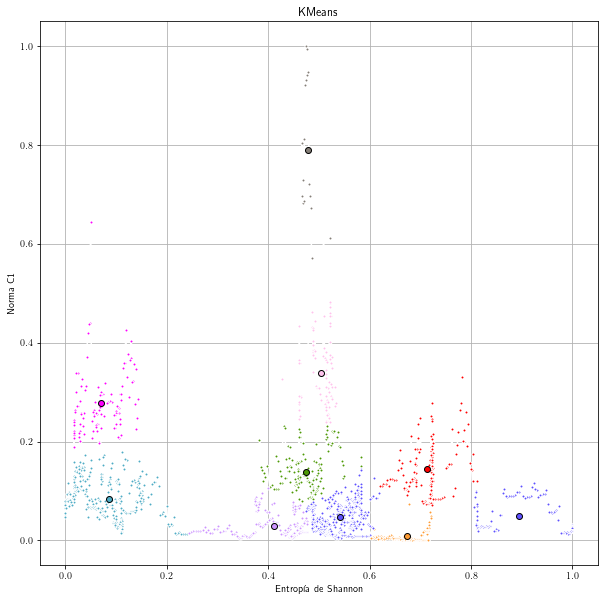

In [15]:
plt.rcParams["figure.figsize"] = (10,10)
n_clusters = 10
kmeans_c1norm = KMeans(n_clusters=n_clusters).fit(np.array(cluster_c1))
k_means_labels = kmeans_c1norm.labels_
k_means_cluster_centers = kmeans_c1norm.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)
colors = ['#4EACC5', '#FF9C34', '#4E9A06','#ffc2ed','#cd94ff','#5e51ff','#ff0000','#847e77','#5e51ff','#ff00ff']
plt.figure()

for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    plt.plot(np.array(cluster_c1)[my_members, 1], np.array(cluster_c1)[my_members, 0], 'w',
            markerfacecolor=col, marker='.')
    plt.plot(cluster_center[1], cluster_center[0], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
plt.title('KMeans')
plt.xlabel('Entropía de Shannon')
plt.ylabel('Norma C1')

plt.grid(True)
plt.show()

In [16]:
km_labels = pd.DataFrame(k_means_labels)
km_labels.index = cluster_c1.index

btc_cl = btc[["Date", "Close"]]
btc_cl = btc_cl.tail(len(km_labels))
btc_cl['clusters'] = km_labels[0].values
print(btc_cl)

btc_cl.to_csv('kmeans_'+str(moneda)+'_'+'MA_'+str(window_MA)+'.csv', encoding='utf-8', index=True)


           Date         Close  clusters
1897 2017-04-14   1175.290346         5
1898 2017-04-15   1173.659340         5
1899 2017-04-16   1175.415980         5
1900 2017-04-17   1189.316678         5
1901 2017-04-18   1205.542681         5
...         ...           ...       ...
3721 2022-04-12  40127.183594         0
3722 2022-04-13  41166.730469         0
3723 2022-04-14  39935.515625         0
3724 2022-04-15  40553.464844         0
3725 2022-04-16  40535.152344         0

[1829 rows x 3 columns]


In [ ]:
#btc_cl['clusters'] = btc_cl['clusters'].astype('category')
btc_cl = btc_cl.rename(columns={"Close":"Metric"})
cluster_c1 = cluster_c1.rename(columns={"C1 norm":"Metric"})
cluster_c1["Date"] = cluster_c1.index
cluster_c2 = cluster_c1[["Date","Metric"]]
k_m = k_m.rename(columns={"Close":"Metric"})
k_m["Date"] = k_m.index
k_m = k_m.loc[k_m['Date'] >= cluster_c2.Date[0]]


df_keys = pd.concat([btc_cl,cluster_c2, k_m], keys=['Finance', 'Topology', "Entropy"])
df_keys["Feature"] = "Topology"
len_topology = len(cluster_c2.Metric)
len_shannon = len(k_m.Metric)
len_finance = len(btc_cl.Metric)

df_keys.loc[df_keys.tail(len_shannon).index, 'Feature'] =  "Entropy"
df_keys.loc[df_keys.head(len_finance).index, 'Feature'] =  "Finance"
df_keys.clusters[len_finance:len_finance+len_topology] = 10
df_keys.clusters[len_finance+len_topology:len_finance+len_topology+len_shannon] = 11

df_keys['clusters'] = df_keys['clusters'].astype('category')

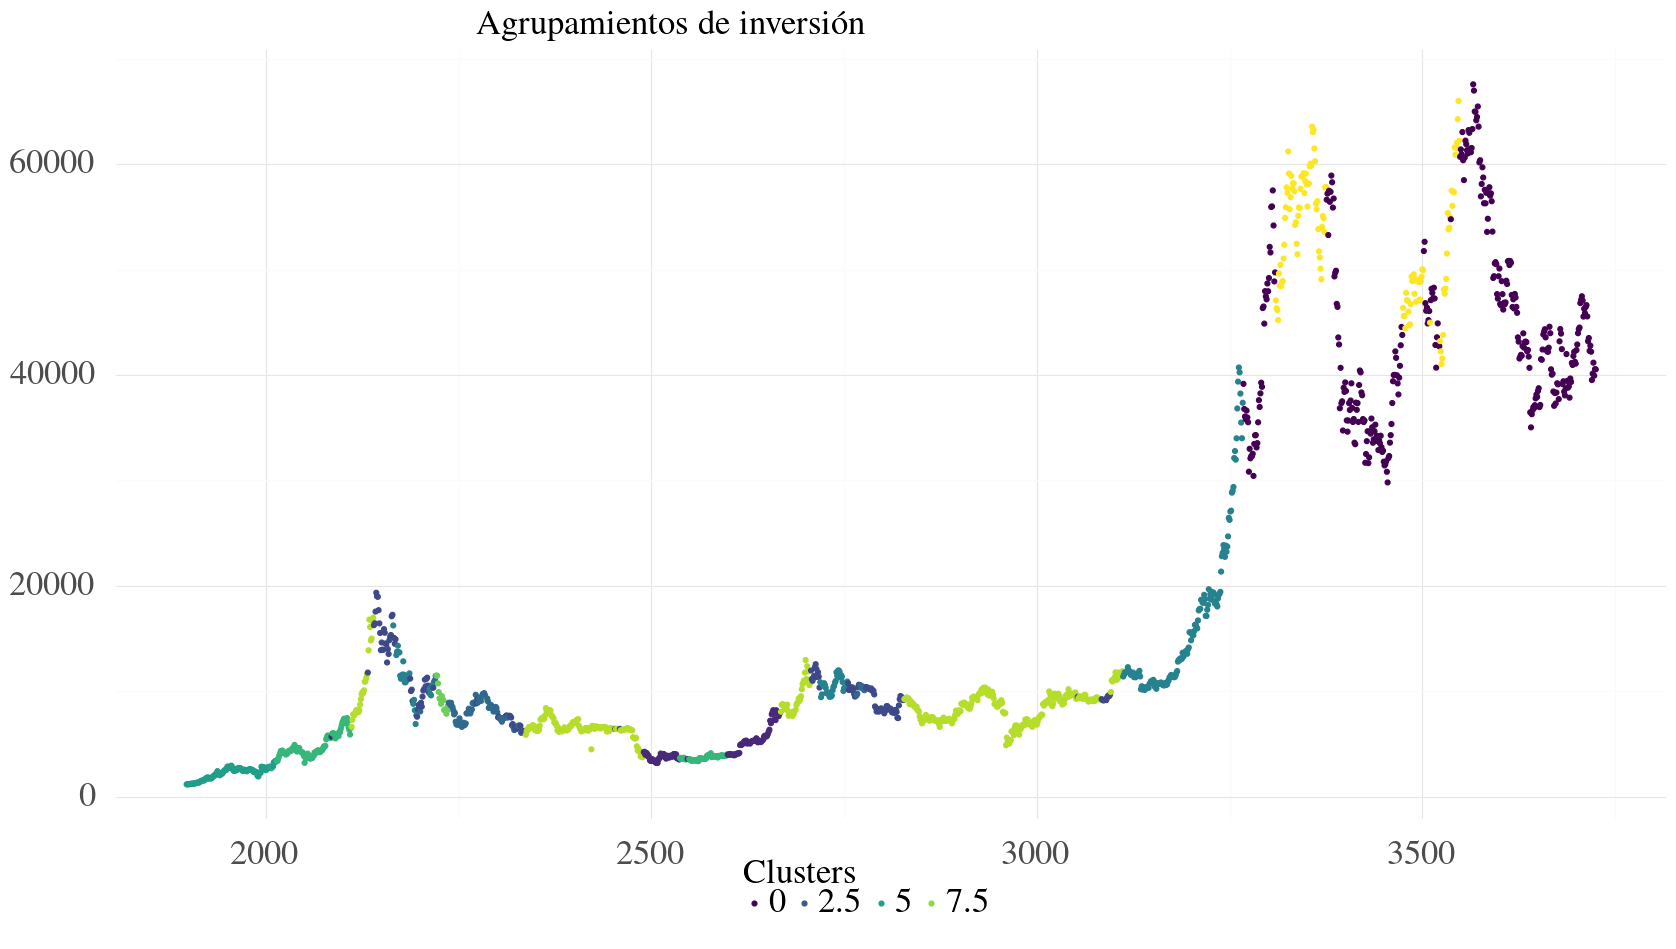

<ggplot: (8762644863994)>

In [44]:
fig = (
    ggplot(btc_cl, aes(x=btc_cl.index , y= 'Metric',color = "clusters"))
    + geom_point(data = btc_cl)
    + theme_minimal()
    + labs(title = "Agrupamientos de inversión",subtitle = "2017-02-24 / 2022-04-10",x = " ", y = " ")
    + theme(
        plot_title = element_text(hjust = 1),
        #dpi=100,
        figure_size=(20,10), # inches
        #aspect_ratio=1/3    # height:width
        legend_position = "bottom",
        text=element_text(size=25)
    )
    + guides(colour = guide_legend(title = "Clusters", title_position = "top", nrow = 1))
)

fig

In [77]:
fig = px.scatter(df_keys, x="Date", y="Metric", title = "Clusters",color = "clusters", facet_row="Feature", width=950, height=720)
trace_price = go.Scatter(
    x=df_keys.Date[0:len_finance] ,
    y=df_keys.Metric[0:len_finance],
    name='Price USD',
    line_color='rgb(100, 100, 100)',
    opacity = 0.3
)
fig.add_trace(trace_price, row=3, col = 1)

trace_topology = go.Scatter(
    x=df_keys.Date[len_finance:len_finance+len_topology] ,
    y=df_keys.Metric[len_finance:len_finance+len_topology],
    name='C^1 Norm',
    line_color='rgb(0, 0, 255)',
    opacity = 0.3
)
fig.add_trace(trace_topology, row=2, col = 1)

fig.update_yaxes(matches=None)
fig.add_vrect(x0="2017-12-10", x1="2018-02-05", col=1,
              annotation_text="Caída", annotation_position="top left",
              fillcolor="red", opacity=0.05, line_width=0)

fig.add_vrect(x0="2018-11-10", x1="2019-02-07", col=1,
              annotation_text="Caída", annotation_position="top left",
              fillcolor="orange", opacity=0.05, line_width=0)

fig.add_vrect(x0="2019-06-20", x1="2019-07-30", col=1,
              annotation_text="Caída", annotation_position="top left",
              fillcolor="red", opacity=0.05, line_width=0)

fig.add_vrect(x0="2020-02-14", x1="2020-03-18", col=1,
              annotation_text="Caída", annotation_position="top left",
              fillcolor="orange", opacity=0.05, line_width=0)

fig.add_vrect(x0="2021-01-07", x1="2021-02-07", col=1,
              annotation_text="Caída", annotation_position="top left",
              fillcolor="red", opacity=0.05, line_width=0)

fig.add_vrect(x0="2021-05-08", x1="2021-07-20", col=1,
              annotation_text="Caída", annotation_position="top left",
              fillcolor="orange", opacity=0.05, line_width=0)

fig.add_vrect(x0="2021-11-01", x1="2022-01-22", col=1,
              annotation_text="Caída", annotation_position="top left",
              fillcolor="orange", opacity=0.05, line_width=0)

fig['layout'].update(width=950, height=950, autosize=False)

fig.show()


El anáisis topológico de datos nos ayuda a preveer caídas significativas después de un crecimiento constante en periodos cortos de tiempo. Entre mayor sea la norma $C^1$ mayor será la caída después del aumento del precio. Como se muestra en el crash del 2018, en una semana el precio bajo un 26% con respecto al actual. A mediados del 2019 el precio sufrió una caída aproximada del 25% en 7 días mostrando una caracteristica topológica igualmente alta. Por otro lado, a inicios de 2021, del 14 de enero al 21 de enero hubo una caída significativa del 29% en 7 días. Fijandonos en la entropía calculada, ésta caracteriza las bajadas del precio con un pequeño valle en la serie de tiempo.

Si la caída ocurre mientras el precio se mantiene relativamente constante o en un periodo largo de tiempo como en los periodos de 2019, 2020, 2021 y 2022 la norma $C^1$ muestra un aumento pero no de forma drástica. La entropía captura mesetas en estos periodos de tiempo que entre más pronunciadas, mayor es la norma $C^1$.

Con las caracteristicas anteriores se crea un plano que tiene por eje $x$ la entropía normalizada y en el eje $y$ la norma $C^1$ igualmente normalizada. Se agrupan los puntos con el algoritmo k-means de tal forma que estos nos ayuden a detectar las subidas y bajadas del precio para caracterizar la toma de desiciones de inversión.

Los cluster de caída son validos si hay fechas consecutivas en los mismos, y además son de alto riesgo si tienen una norma mayor que 0.5.

### Clusters de inversión
Cuando el precio baja (o hay una caída) se recomienda comprar, cuando sube se recomienda vender

Compra: 2,3,7,0

Vende: 4,5,6,8,9

Incertidumbre: 1

## Generación de imagenes

Creación de imagenes y guardado de las mismas con su correspondiente agrupamiento de inversión.

In [78]:
#Algoritmo de creación de imagenes a partir de datos transformados.
import os
import time
import threading
import multiprocessing
import os
import pandas as pd
import numpy as np
from PIL import Image

NUM_WORKERS = 4

def image():
    tam = 32
    tam2 = tam*tam
    dataset = pd.DataFrame()
    count = 0
    # Entre mayor sea window_ mayor será el numero de imagenes generadas
    window_ = 50
    dataset = pd.read_csv('/Users/sacbe/Documents/Tesis licenciatura/Algoritmos/kmeans_'+str(moneda)+'_'+'MA_'+str(window_MA)+'.csv', sep = ',')
    count = 0
    data_group = dataset['clusters']
    dataset = dataset['Close']
    print(len(dataset))
    if(window_MA+window_shannon < window_):
        print("Advertencia: la longitud de los datos es menor a lo requerido. Intenta que window_MA+window_shannon >= window_")

    for i in range(0,(len(dataset) - tam2), tam):
        for j in range(i,(window_+i)):
            data_img = dataset[j:tam2+1+j]
            data_label = data_group[j:tam2+1+j]
            count += 1
            x = 0 
            y = 0
            mini = min(data_img)
            maxi = max(data_img)
            df = np.zeros((tam, tam)).astype(np.uint8)
            for k in range(j, tam2+j-window_MA-window_shannon):
                df[y][x] = round((data_img[k] - mini) / (maxi - mini)*255)
                x+=1
                if(x == tam):
                    y+=1
                    x = 0
            img = Image.fromarray(df)
            img.save('/Users/sacbe/Documents/Tesis licenciatura/Algoritmos/IMG/'+str(moneda)+'_'+str(window_MA)+'/'+str(count)+'_'+str(data_label[j])+'.png')
    print('Imagenes guardadas.')


def only_sleep():
    
    lista = [0,1,2,3]

    if(multiprocessing.current_process().name == "Process-1"):
    	image(lista[0])
    elif(multiprocessing.current_process().name == "Process-2"):
    	image(lista[1])
    elif(multiprocessing.current_process().name == "Process-3"):
    	image(lista[2])
    elif(multiprocessing.current_process().name == "Process-4"):
        image(lista[3])


def main(): 
    start_time = time.time()
    end_time = time.time()


    start_time = time.time()
    processes = [multiprocessing.Process(target=only_sleep) for _ in range(NUM_WORKERS)]
    [process.start() for process in processes]
    [process.join() for process in processes]
    end_time = time.time()
     
    print("Threads time=", end_time - start_time)
 

if __name__ == '__main__':
    main()

Threads time= 0.17641401290893555


In [79]:
%%time
#Guardado de imagenes.
image()

1829
Imagenes guardadas.
CPU times: user 4.46 s, sys: 99.6 ms, total: 4.56 s
Wall time: 4.61 s
